# Actividad para resolver la tarea de identificación de Captchas

Hemos estudiado y comprendido los conceptos de redes convolucionales, sus principales arquitecturas y su aplicación en tareas de clasificación de imágenes. Ahora, es momento de aplicar estos conocimientos en una tarea particular: la identificación de Captchas. Para este problema, usamos la base de datos disponible en [Captcha](https://www.researchgate.net/publication/248380891_CAPTCHA_dataset).

## Etapa 1: Carga de los datos

In [2]:
import numpy as np

%matplotlib inline
from keras.utils import plot_model
import matplotlib.pyplot as plt
import os
from keras import layers
from keras.models import Model
from keras.models import load_model
import cv2
import string

Se descarga la base de datos como un archivo `.zip`, el archivo quedará almacenado dentro de la sesión de Google Colab, no ocupa espacio en nuestro disco.

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf" -O "Data.zip" && rm -rf /tmp/cookies.txt

--2024-10-05 17:11:34--  https://docs.google.com/uc?export=download&confirm=&id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf
Resolving docs.google.com (docs.google.com)... 142.251.2.102, 142.251.2.139, 142.251.2.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf&export=download [following]
--2024-10-05 17:11:35--  https://drive.usercontent.google.com/download?id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10036086 (9.6M) [application/octet-stream]
Saving to: ‘Data.zip’

Data.zip            100%[===================>]   9.57M  50.4MB/s    in 

In [4]:
# Se descomprime el archivo zip para acceder a las imágenes.
!unzip Data.zip -d Data

Archive:  Data.zip
   creating: Data/captcha_dataset/
  inflating: Data/__MACOSX/._captcha_dataset  
  inflating: Data/captcha_dataset/.DS_Store  
  inflating: Data/__MACOSX/captcha_dataset/._.DS_Store  
  inflating: Data/captcha_dataset/ml_data_3188.csv  
  inflating: Data/__MACOSX/captcha_dataset/._ml_data_3188.csv  
   creating: Data/captcha_dataset/samples/
  inflating: Data/__MACOSX/captcha_dataset/._samples  
  inflating: Data/captcha_dataset/ml_test_3188.csv  
  inflating: Data/__MACOSX/captcha_dataset/._ml_test_3188.csv  
  inflating: Data/captcha_dataset/samples/p5g5m.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._p5g5m.png  
  inflating: Data/captcha_dataset/samples/e72cd.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._e72cd.png  
  inflating: Data/captcha_dataset/samples/pgmn2.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._pgmn2.png  
  inflating: Data/captcha_dataset/samples/6cm6m.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._

In [5]:
# Se calcula la cantidad de imágenes en la base de datos
N = len(os.listdir("Data/captcha_dataset/samples"))
print(N)

1070


In [6]:
# Se define el tamaño de las imágenes requerido.
Ishape=(50,200,1) # Un canal debido a que son imágenes en escala de grises

In [7]:
# Número de posibles caracteres en las imágenes
character= string.ascii_lowercase + "0123456789" # todos los símbolos que puede
                                                 # contener un captcha, las letras
                                                 # del abecedario y los números
                                                 # [0,9]
# número de posibles caracteres
N_char = len(character)
N_char

36

Se definen algunas funciones importantes para la carga y procesamiento de las imágenes.

In [8]:
# Función para la carga y proceso de las imágenes.
def load_process():
  X = np.zeros((N,)+Ishape) # Arreglo que contiene las imágenes.
  y = np.zeros((N, 5)) # Arreglo que contiene las etiquetas.
  lab = [] # se almacenan las etiquetas en formato de texto.

  # Se cargan las imágenes de la base de datos
  file_dir = 'Data/captcha_dataset/samples'
  for i, ima in enumerate(os.listdir(file_dir)):

    # Se leen las imágenes en escala de grises.
    img = cv2.imread(os.path.join(file_dir, ima), cv2.IMREAD_GRAYSCALE)
    label = ima[:-4] # el nombre del archivo que corresponde con su etiqueta
    if len(label) < 6:
      lab.append(label)
      img = img / 255.0 # se reescala la imagen
      img = np.reshape(img, Ishape) # se cambia el tamaño de las imágenes

      # Convierte cada caracter de la etiqueta en un número. Por ejemplo, el
      # caracter 'a' se codifica como 0.
      for j, car in enumerate(label):
         index = character.find(car)
         y[i,j] = index

      X[i,:] = img


  return X, y, lab


<ipython-input-9-f1e74cbc05a1>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


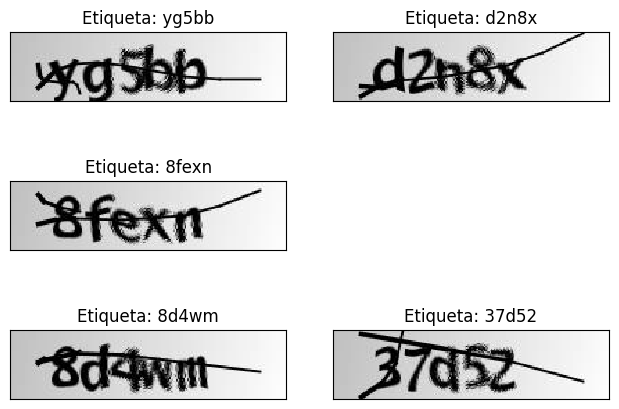

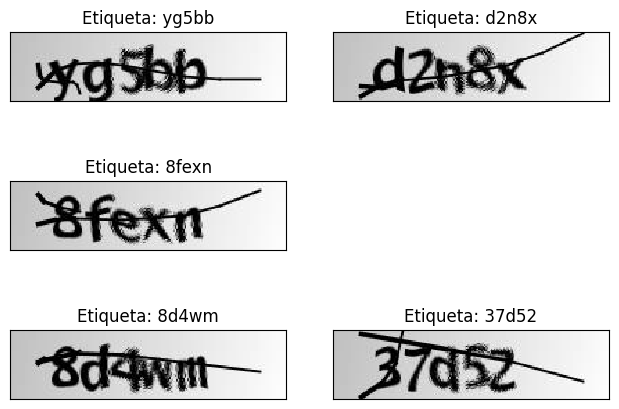

In [9]:
# Se cargan los datos y se muestran algunas imágenes
X, y, label = load_process()
fig = plt.figure()
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.tight_layout()
  plt.imshow(X[i,:,:,0], cmap='gray', interpolation='none')
  plt.title("Etiqueta: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [10]:
print(X.shape, y.shape)

(1070, 50, 200, 1) (1070, 5)


Se definen los datos de entrenamiento y prueba.

In [11]:
# De las 1070 muestras, se usan 970 para el entrenamiento y 100 para la prueba.
x_train, y_train = X[:970,:,:,:], y[:970,:]
x_test, y_test = X[970:,:,:,:], y[970:,:]